In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.python.client import device_lib
from nltk.tokenize import word_tokenize
import collections
import csv
import re
import pylab
import time
import json
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
# Default variables
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
EMBEDDING_SIZE = 20

batch_size = 128
no_epochs = 250
lr = 0.01
use_dropout = True

seed = 10
tf.random.set_seed(seed)

In [17]:
# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpus)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        devices = device_lib.list_local_devices()
        avail_gpu = [x for x in devices if x.device_type == 'GPU']
        print('\n',avail_gpu)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No gpus available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs

 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3048682292
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9751146049270845100
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [18]:
# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

In [19]:
def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict

In [20]:
def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x

In [21]:
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./data/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./data/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))
            
    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1

    return x_train, y_train, x_test, y_test, vocab_size

In [22]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text

In [23]:
def load_history(model_name, dropout):
    if dropout:
        with open(f'./histories/{model_name}_dropout') as file:
            history = json.load(file)
    else:
        with open(f'./histories/{model_name}_nodropout') as file:
            history = json.load(file)
    return history

In [24]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [25]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [26]:
tf.keras.backend.set_floatx('float32')
class WordCNN(tf.keras.Model):
    def __init__(self, vocab_size, drop_rate):
        super(WordCNN, self).__init__()
        self.vocab_size = vocab_size
        self.drop_rate = drop_rate
        
        # Weight variables and RNN cell
        self.embedding = tf.keras.layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        self.conv1 = tf.keras.layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = tf.keras.layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = tf.keras.layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.pool2 = tf.keras.layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate):
        # forward
        x = self.embedding(x)
        x = x[..., tf.newaxis]
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)    
        x = self.flatten(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [27]:
x_train, y_train, x_test, y_test, vocab_size = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Build model
tf.keras.backend.set_floatx('float32')
test_acc = []
train_acc = []
test_l = []
train_l = []

In [14]:
print(x_train[0])

tf.Tensor(
[  240 14309     6     7    75  6537    33    21  1909   240   416  6538
    37   362    11     9    54     4  1325    10     3  5285  1482   658
     5  5285    40   752    11     6     7  4445  8867 14310  1144     8
  8868    89     3  6537  3457   982   334   206    10   307   334   529
     8    29    16  2466  3458  2187  3151  4446   290   334    10   265
   334   464  1800    27    14     3  1555     6     7  2307  8867 14311
   733  2890  4447    27  4448     4  1325     2     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int64)


In [28]:
name = 'WordCNN'

if use_dropout:
    model = WordCNN(vocab_size,0.5)
else:
    model = WordCNN(vocab_size,0)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [29]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [86]:
start_time = time.perf_counter()
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    if use_dropout:
        for images, labels in train_ds:
            train_step(model, images, labels, drop_rate=0.5)
    else:
        for images, labels in train_ds:
            train_step(model, images, labels, drop_rate=0)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    test_acc.append(test_accuracy.result().numpy().astype(float))
    train_acc.append(train_accuracy.result().numpy().astype(float))
    test_l.append(test_loss.result().numpy().astype(float))
    train_l.append(train_loss.result().numpy().astype(float))
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
end_time = time.perf_counter()
time_taken = end_time-start_time
print("Time taken for training: "+str(time_taken))

Epoch 1, Loss: 0.26592710614204407, Accuracy: 0.9158928394317627, Test Loss: 1.1385871171951294, Test Accuracy: 0.7442857027053833
Epoch 2, Loss: 0.2668199837207794, Accuracy: 0.9160714149475098, Test Loss: 1.088435173034668, Test Accuracy: 0.7642857432365417
Epoch 3, Loss: 0.25996527075767517, Accuracy: 0.9192857146263123, Test Loss: 1.1074298620224, Test Accuracy: 0.7542856931686401
Epoch 4, Loss: 0.27092650532722473, Accuracy: 0.9158928394317627, Test Loss: 1.0851038694381714, Test Accuracy: 0.7614285945892334
Epoch 5, Loss: 0.2887239158153534, Accuracy: 0.90625, Test Loss: 1.070684552192688, Test Accuracy: 0.7642857432365417
Epoch 6, Loss: 0.2644760012626648, Accuracy: 0.9171428680419922, Test Loss: 1.1646463871002197, Test Accuracy: 0.758571445941925
Epoch 7, Loss: 0.26225191354751587, Accuracy: 0.916607141494751, Test Loss: 1.0706403255462646, Test Accuracy: 0.7614285945892334
Epoch 8, Loss: 0.263043075799942, Accuracy: 0.9196428656578064, Test Loss: 1.1010929346084595, Test Accu

Epoch 64, Loss: 0.21200934052467346, Accuracy: 0.9364285469055176, Test Loss: 1.1962172985076904, Test Accuracy: 0.7699999809265137
Epoch 65, Loss: 0.21315674483776093, Accuracy: 0.9373214244842529, Test Loss: 1.1657943725585938, Test Accuracy: 0.7642857432365417
Epoch 66, Loss: 0.21022778749465942, Accuracy: 0.9385714530944824, Test Loss: 1.2089875936508179, Test Accuracy: 0.7628571391105652
Epoch 67, Loss: 0.21500061452388763, Accuracy: 0.9332143068313599, Test Loss: 1.173490047454834, Test Accuracy: 0.7628571391105652
Epoch 68, Loss: 0.21133221685886383, Accuracy: 0.9371428489685059, Test Loss: 1.264665961265564, Test Accuracy: 0.7557142972946167
Epoch 69, Loss: 0.20736193656921387, Accuracy: 0.9398214221000671, Test Loss: 1.1810575723648071, Test Accuracy: 0.7642857432365417
Epoch 70, Loss: 0.19755937159061432, Accuracy: 0.9373214244842529, Test Loss: 1.2470351457595825, Test Accuracy: 0.7685714364051819
Epoch 71, Loss: 0.2091342806816101, Accuracy: 0.9341071248054504, Test Loss: 1

Epoch 127, Loss: 0.16279791295528412, Accuracy: 0.9544642567634583, Test Loss: 1.281877875328064, Test Accuracy: 0.772857129573822
Epoch 128, Loss: 0.18073779344558716, Accuracy: 0.9446428418159485, Test Loss: 1.2648180723190308, Test Accuracy: 0.7642857432365417
Epoch 129, Loss: 0.17443393170833588, Accuracy: 0.9496428370475769, Test Loss: 1.3241136074066162, Test Accuracy: 0.7614285945892334
Epoch 130, Loss: 0.16820229589939117, Accuracy: 0.9503571391105652, Test Loss: 1.289305567741394, Test Accuracy: 0.7642857432365417
Epoch 131, Loss: 0.17733703553676605, Accuracy: 0.947857141494751, Test Loss: 1.3124440908432007, Test Accuracy: 0.7542856931686401
Epoch 132, Loss: 0.17609582841396332, Accuracy: 0.9437500238418579, Test Loss: 1.3239508867263794, Test Accuracy: 0.7642857432365417
Epoch 133, Loss: 0.16344279050827026, Accuracy: 0.9512500166893005, Test Loss: 1.286051630973816, Test Accuracy: 0.7757142782211304
Epoch 134, Loss: 0.17918124794960022, Accuracy: 0.9455357193946838, Test L

Epoch 189, Loss: 0.15317820012569427, Accuracy: 0.9549999833106995, Test Loss: 1.4211115837097168, Test Accuracy: 0.7785714268684387
Epoch 190, Loss: 0.1455851048231125, Accuracy: 0.9555357098579407, Test Loss: 1.396243929862976, Test Accuracy: 0.772857129573822
Epoch 191, Loss: 0.1477363258600235, Accuracy: 0.956250011920929, Test Loss: 1.3825045824050903, Test Accuracy: 0.7671428322792053
Epoch 192, Loss: 0.14953702688217163, Accuracy: 0.9573214054107666, Test Loss: 1.3897180557250977, Test Accuracy: 0.7742857336997986
Epoch 193, Loss: 0.14354757964611053, Accuracy: 0.9630357027053833, Test Loss: 1.3512223958969116, Test Accuracy: 0.7742857336997986
Epoch 194, Loss: 0.14417624473571777, Accuracy: 0.9558928608894348, Test Loss: 1.4141439199447632, Test Accuracy: 0.772857129573822
Epoch 195, Loss: 0.14031732082366943, Accuracy: 0.9621428847312927, Test Loss: 1.3813691139221191, Test Accuracy: 0.7699999809265137
Epoch 196, Loss: 0.1469627469778061, Accuracy: 0.9549999833106995, Test Los

In [87]:
print("Time taken for training:"+str(time_taken))

Time taken for training:224.5227476


In [88]:
history = {name: {
    'accuracy': train_acc,
    'val_acc': test_acc,
    'loss': train_l,
    'val_loss': test_l,
    'time_taken': time_taken
}}

if use_dropout:
    with open(f'./histories/{name}_dropout', 'w') as file:
        json.dump(history, file)
else:
    with open(f'./histories/{name}_nodropout', 'w') as file:
        json.dump(history, file)

In [89]:
for keys in history[name]:
    print(keys)
    print(history[name][keys])

accuracy
[0.07392857223749161, 0.07964285463094711, 0.07285714149475098, 0.06964285671710968, 0.07035714387893677, 0.0682142823934555, 0.07803571224212646, 0.07160714268684387, 0.07500000298023224, 0.07035714387893677, 0.0791071429848671, 0.07285714149475098, 0.07821428775787354, 0.07196428626775742, 0.07678571343421936, 0.0746428593993187, 0.07107143104076385, 0.07446428388357162, 0.07392857223749161, 0.0746428593993187, 0.07839285582304001, 0.07571428269147873, 0.07374999672174454, 0.0726785734295845, 0.07874999940395355, 0.07446428388357162, 0.07839285582304001, 0.0758928582072258, 0.06785714626312256, 0.08392857015132904, 0.08589285612106323, 0.08178571611642838, 0.0803571417927742, 0.08535714447498322, 0.08303571492433548, 0.07035714387893677, 0.08339285850524902, 0.08517856895923615, 0.08232142776250839, 0.08410714566707611, 0.08428571373224258, 0.0880357176065445, 0.08642856776714325, 0.0925000011920929, 0.08714285492897034, 0.09035713970661163, 0.08196428418159485, 0.0901785716

In [90]:
history = load_history('WordCNN',False)

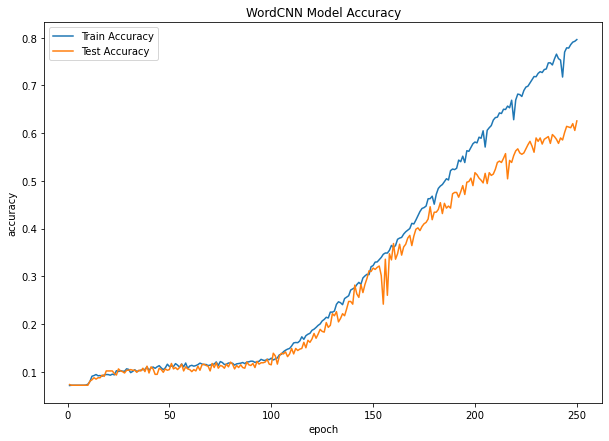

In [93]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(history[name]['accuracy']) + 1), 
         history[name]['accuracy'], label='Train Accuracy')
plt.plot(range(1, len(history[name]['accuracy']) + 1), 
         history[name]['val_acc'], label='Test Accuracy')
plt.title(f'{name} Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig(
            f'./results/QuestionB2_{name}_accuracy.pdf'
        )

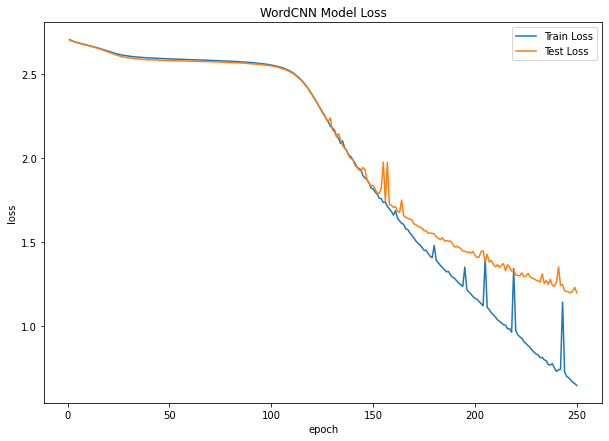

In [94]:
plt.figure(figsize=(10,7))
plt.plot(range(1, len(history[name]['loss']) + 1), 
         history[name]['loss'], label='Train Loss')
plt.plot(range(1, len(history[name]['loss']) + 1), 
         history[name]['val_loss'], label='Test Loss')
plt.title(f'{name} Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(
            f'./results/QuestionB2_{name}_loss.pdf'
        )